# Introduction


*[Write your introduction here — describe the context, motivation, and scope of the analysis.]*

> **To export to Word:** run `jupyter nbconvert --to docx report.ipynb` in the terminal (requires [pandoc](https://pandoc.org/)).


# Data Sources


| Source | Series | Coverage |
|--------|--------|----------|
| [FAOSTAT](https://www.fao.org/faostat) — Emissions by subsector | Annual GHG emissions by country and gas type (kt) | 1990-2021 |
| [World Bank](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD) — `NY.GDP.MKTP.KD` | GDP in constant 2015 USD | 1990–2024 |
| [UNSD M49](https://unstats.un.org/unsd/methodology/m49/overview/) — Country classification | ISO3 codes and regional groupings | — |

Countries analysed: **Germany, France, Italy, Spain**.


# Methodology


The following steps were applied:

1. **Load emissions** — FAOSTAT CSV filtered to `Area`, `Element`, `Year`, `Value`.
2. **Attach ISO3 codes** — M49 area codes joined to the UNSD lookup for ISO3 and continental classification.
3. **Fetch GDP** — World Bank REST API queried for constant-2015-USD GDP (1990–2024).
4. **Merge and filter** — GDP joined on `ISO3 x Year`; rows missing GDP dropped.
5. **Emissions intensity** — `emissions / (GDP / 1 000 000)` (kt per million USD).
6. **Emissions index** — Each country-gas series re-indexed to 100 at 1990.
7. **Trend summary** — Percent change from 1990 to latest year; OLS slope of the index series.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path

pd.set_option('display.float_format', '{:,.2f}'.format)
sns.set_theme(style='ticks')

# Config
DATA_PATH        = 'data.csv'
COUNTRIES        = ['Germany', 'France', 'Italy', 'Spain']
GDP_INDICATOR    = 'NY.GDP.MKTP.KD'
GDP_DATE_RANGE   = '1990:2024'
UNSD_M49_URL     = 'https://unstats.un.org/unsd/methodology/m49/overview/'
METRIC_EMISSIONS = 'Emissions'
METRIC_INTENSITY = 'Emissions Intensity (per Million $USD GDP)'


def load_emissions(path):
    cols = ['Area Code (M49)', 'Area', 'Element Code', 'Element',
            'Year Code', 'Year', 'Value']
    df = pd.read_csv(path, usecols=cols).copy()
    df['Year']  = pd.to_numeric(df['Year'],  errors='coerce')
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df['Area Code (M49)'] = df['Area Code (M49)'].astype('category')
    df['area_code_str']   = df['Area Code (M49)'].astype(int).astype(str).str.zfill(3)
    df['Element'] = df['Element'].str.replace(r'^Emissions \((.+)\)$', r'\1', regex=True)
    return df


def load_unsd_m49_lookup(url):
    tables = pd.read_html(url)
    m49 = next(t for t in tables if 'M49 Code' in t.columns).copy()
    m49['m49_code_str'] = m49['M49 Code'].astype(str).str.zfill(3)
    m49['ISO3']         = m49['ISO-alpha3 Code'].astype(str).str.strip()
    return m49[['m49_code_str', 'Region Name', 'ISO3']].drop_duplicates()


def add_continent_and_iso3(emissions, m49_lookup):
    out = emissions.merge(m49_lookup, left_on='area_code_str',
                          right_on='m49_code_str', how='left')
    return out.drop(columns=['m49_code_str']).rename(columns={'Region Name': 'Continent'})


def fetch_world_bank_gdp(indicator, date_range):
    url  = (f'https://api.worldbank.org/v2/country/all/indicator/{indicator}'
            f'?date={date_range}&format=json&per_page=20000')
    resp = requests.get(url).json()
    if len(resp) < 2:
        raise ValueError(resp)
    gdp = pd.DataFrame(resp[1])[['countryiso3code', 'country', 'date', 'value']].copy()
    gdp.columns = ['ISO3', 'Country_WB', 'Year', 'GDP_constant_USD']
    gdp['ISO3']             = gdp['ISO3'].astype(str).str.strip()
    gdp['Year']             = pd.to_numeric(gdp['Year'], errors='coerce')
    gdp['GDP_constant_USD'] = pd.to_numeric(gdp['GDP_constant_USD'], errors='coerce')
    gdp = gdp.dropna(subset=['ISO3', 'Year', 'GDP_constant_USD']).copy()
    gdp['Year'] = gdp['Year'].astype(int)
    return gdp


def merge_gdp(emissions, gdp):
    out = emissions.merge(gdp[['ISO3', 'Year', 'GDP_constant_USD']],
                          on=['ISO3', 'Year'], how='left')
    out = out.dropna(subset=['Year', 'GDP_constant_USD']).copy()
    out['Year'] = out['Year'].astype(int)
    return out


def add_intensity(df):
    out = df.copy()
    out['emissions_per_million_usd'] = out['Value'] / (out['GDP_constant_USD'] / 1_000_000)
    return out


def add_index_1990(df, value_col, group_cols, out_col):
    base = (df[df['Year'] == 1990]
            .groupby(group_cols, as_index=False)[value_col]
            .mean()
            .rename(columns={value_col: f'{value_col}_1990'}))
    out = df.merge(base, on=group_cols, how='left')
    out[out_col] = out[value_col] / out[f'{value_col}_1990'] * 100
    return out


def plot_emissions_and_intensity_facets(df, countries, out_path=None):
    palette = dict(zip(countries, sns.color_palette('colorblind', n_colors=len(countries))))
    plot_df = pd.concat([
        df[['Area', 'Element', 'Year', 'Value']]
          .rename(columns={'Value': 'Y'}).assign(Metric=METRIC_EMISSIONS),
        df[['Area', 'Element', 'Year', 'emissions_per_million_usd']]
          .rename(columns={'emissions_per_million_usd': 'Y'}).assign(Metric=METRIC_INTENSITY),
    ], ignore_index=True).dropna(subset=['Year', 'Y'])
    with sns.axes_style('ticks'):
        f = sns.relplot(data=plot_df, x='Year', y='Y',
                        hue='Area', hue_order=countries, palette=palette,
                        row='Element', col='Metric',
                        col_order=[METRIC_EMISSIONS, METRIC_INTENSITY],
                        kind='line', height=3.5, aspect=1.4,
                        linewidth=1.0, legend=False,
                        facet_kws={'sharex': True, 'sharey': False})
    col_short = {METRIC_EMISSIONS: 'Emissions (kt)', METRIC_INTENSITY: 'Emissions Intensity (kt / M USD)'}
    # Column headers on top row only
    for j, col_val in enumerate(f.col_names):
        f.axes[0, j].set_title(col_short[col_val])
    for i in range(1, len(f.row_names)):
        for j in range(len(f.col_names)):
            f.axes[i, j].set_title('')
    # Gas label on left side of each row
    for i, row_val in enumerate(f.row_names):
        f.axes[i, 0].annotate(
            row_val,
            xy=(0, 0.5), xycoords='axes fraction',
            xytext=(-0.22, 0.5), textcoords='axes fraction',
            ha='right', va='center', fontsize=9, annotation_clip=False,
        )
    f.set_axis_labels('Year', '')
    f.fig.subplots_adjust(wspace=0.4)
    xmin, xmax = f.axes.flat[0].get_xlim()
    f.axes.flat[0].set_xlim(xmin, xmax + 10)
    for ax in f.axes.flat:
        sns.despine(ax=ax, offset=8)
        data_lines = [l for l in ax.get_lines() if len(l.get_xdata()) > 2]
        for line, country in zip(data_lines, countries):
            xdata = np.asarray(line.get_xdata(), dtype=float)
            ydata = np.asarray(line.get_ydata(), dtype=float)
            valid = ~(np.isnan(xdata) | np.isnan(ydata))
            if valid.any():
                ax.annotate(country,
                            xy=(xdata[valid][-1], ydata[valid][-1]),
                            xytext=(5, 0), textcoords='offset points',
                            va='center', fontsize=7, color=line.get_color())
    if out_path:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        f.fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_emissions_index_facets(df, countries, index_col, out_path=None):
    palette = dict(zip(countries, sns.color_palette('colorblind', n_colors=len(countries))))
    with sns.axes_style('ticks'):
        g = sns.relplot(data=df.dropna(subset=[index_col]),
                        x='Year', y=index_col,
                        hue='Area', hue_order=countries, palette=palette,
                        row='Element', kind='line',
                        height=3.5, aspect=1.6,
                        linewidth=1.0, legend=False,
                        facet_kws={'sharex': True, 'sharey': True})
    # Column header on top row only
    g.axes[0, 0].set_title('Emissions Index (1990 = 100)')
    for i in range(1, len(g.row_names)):
        g.axes[i, 0].set_title('')
    # Gas label on left side of each row
    for i, row_val in enumerate(g.row_names):
        g.axes[i, 0].annotate(
            row_val,
            xy=(0, 0.5), xycoords='axes fraction',
            xytext=(-0.22, 0.5), textcoords='axes fraction',
            ha='right', va='center', fontsize=9, annotation_clip=False,
        )
    yr_max = int(df.loc[df[index_col].notna(), 'Year'].max())
    g.axes.flat[0].set_xlim(1990, yr_max)
    for ax in g.axes.flat:
        sns.despine(ax=ax, offset=8)
        data_lines = [l for l in ax.get_lines() if len(l.get_xdata()) > 2]
        for line, country in zip(data_lines, countries):
            xdata = np.asarray(line.get_xdata(), dtype=float)
            ydata = np.asarray(line.get_ydata(), dtype=float)
            valid = ~(np.isnan(xdata) | np.isnan(ydata))
            if valid.any():
                ax.annotate(country,
                            xy=(xdata[valid][-1], ydata[valid][-1]),
                            xytext=(5, 0), textcoords='offset points',
                            va='center', fontsize=7, color=line.get_color(),
                            annotation_clip=False)
        # Reference line added last so it is not picked up by the label loop
        ax.axhline(100, linestyle='--', color='#999999', linewidth=0.7, alpha=0.4, zorder=0)
    g.set_axis_labels('Year', '')
    for ax in g.axes.flat:
        ax.set_ylabel('')
    if out_path:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        g.fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()

def compute_percent_change_1990_to_latest(df):
    latest_year = int(df['Year'].max())
    wide = (df[df['Year'].isin([1990, latest_year])]
            .groupby(['Area', 'Element', 'Year'])['Value']
            .mean().unstack())
    wide['percent_change'] = (wide[latest_year] - wide[1990]) / wide[1990] * 100
    wide['latest_year']    = latest_year
    return wide.reset_index()


def compute_index_slopes(df, index_col):
    rows = []
    for (area, element), g in df.dropna(subset=[index_col]).groupby(['Area', 'Element']):
        slope, _ = np.polyfit(g['Year'].to_numpy(), g[index_col].to_numpy(), 1)
        rows.append({'Area': area, 'Element': element, 'Annual_slope': slope})
    return pd.DataFrame(rows)

In [8]:
emissions  = load_emissions(DATA_PATH)
m49_lookup = load_unsd_m49_lookup(UNSD_M49_URL)
emissions  = add_continent_and_iso3(emissions, m49_lookup)
gdp        = fetch_world_bank_gdp(GDP_INDICATOR, GDP_DATE_RANGE)

emissions_we = emissions[emissions['Area'].isin(COUNTRIES)].copy()
emissions_we = merge_gdp(emissions_we, gdp)
emissions_we = add_intensity(emissions_we)
emissions_we = emissions_we.dropna(subset=['Year', 'Value']).copy()
emissions_we['Year'] = emissions_we['Year'].astype(int)
emissions_we = add_index_1990(
    emissions_we, 'Value', ['Area', 'Element'], 'Emissions_index_1990_100'
)

pct_change = compute_percent_change_1990_to_latest(emissions_we)
slopes     = compute_index_slopes(emissions_we, 'Emissions_index_1990_100')

n      = len(emissions_we)
yr_min = int(emissions_we['Year'].min())
yr_max = int(emissions_we['Year'].max())
print(f'Rows: {n:,}  |  Years: {yr_min}-{yr_max}')
print('Elements:', sorted(emissions_we['Element'].unique()))

Rows: 384  |  Years: 1990-2021
Elements: ['Emissions (CH4)', 'Emissions (CO2)', 'Emissions (N2O)']


# Emissions plots


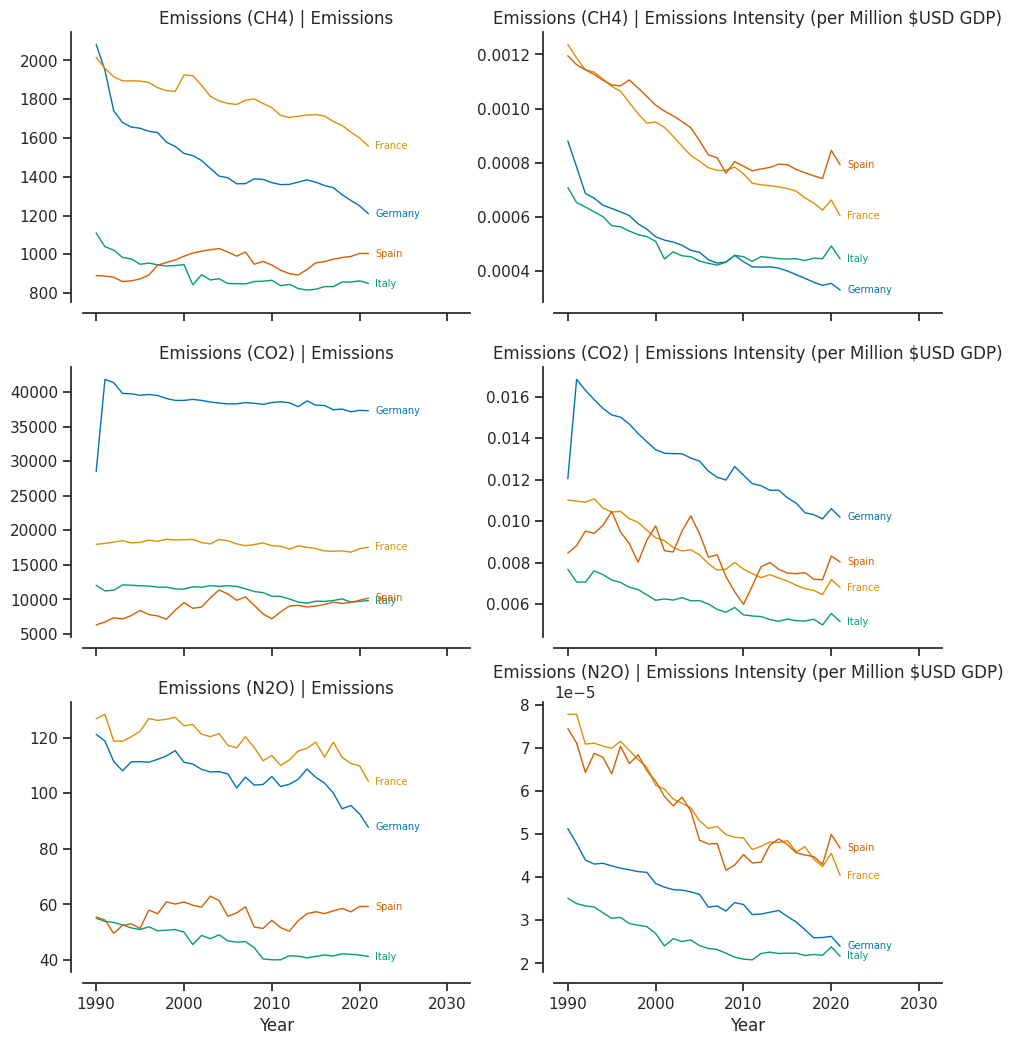

In [9]:
plot_emissions_and_intensity_facets(
    emissions_we, COUNTRIES,
    out_path='Figures/fig1_emissions_intensity.png'
)

# GDP index plot


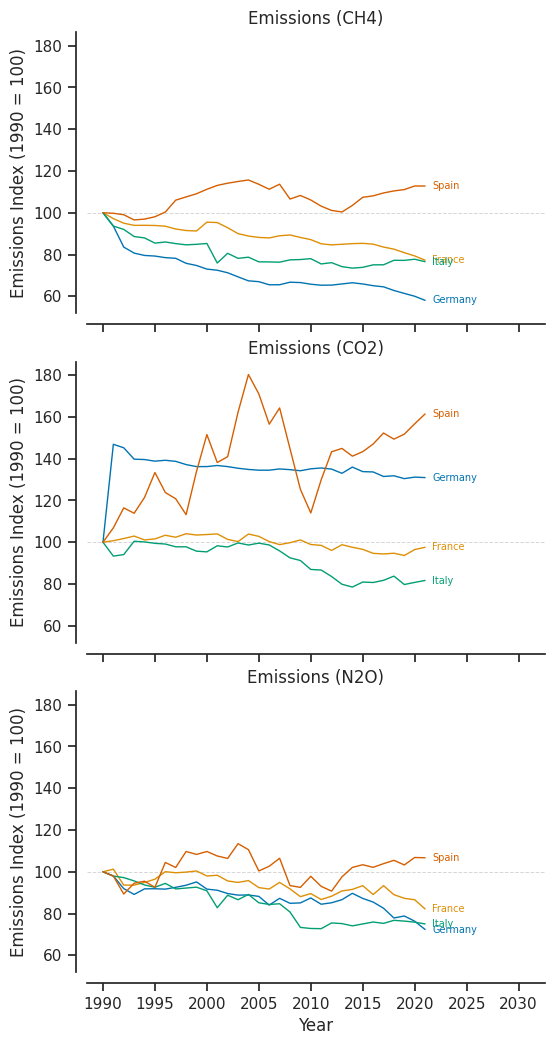

In [10]:
plot_emissions_index_facets(
    emissions_we, COUNTRIES, 'Emissions_index_1990_100',
    out_path='Figures/fig2_emissions_index.png'
)

# % change table

How much do emissions change from 1990 to 2021?


In [ ]:
yr_cols = [c for c in pct_change.columns if isinstance(c, int)]
(
    pct_change
    .sort_values(['Element', 'Area'])
    .reset_index(drop=True)
    .rename(columns={c: f'{c} (kt)' for c in yr_cols})
    .style.format({**{f'{c} (kt)': '{:.2f}' for c in yr_cols},
                   'percent_change': '{:+.1f}%',
                   'latest_year':    '{:.0f}'})
)

# Slope table


In [12]:
(
    slopes
    .pivot(index='Element', columns='Area', values='Annual_slope')
    [COUNTRIES]
    .style.format('{:+.3f}')
)

Area,Germany,France,Italy,Spain
Element,,,,
Emissions (CH4),-0.893,-0.550,-0.588,+0.290
Emissions (CO2),-0.120,-0.262,-0.722,+1.244
Emissions (N2O),-0.551,-0.418,-0.881,+0.110


# Interpretation


*[Write your interpretation here.]*
